In [ ]:
!pip install -q git+https://github.com/ucl-pond/pySuStaIn

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 887.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pySuStaIn
import os
import pickle
import shutil
from pathlib import Path
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score

import AbstractSustain as abstract
import ZscoreSustain_sigma as zscore

data = np.loadtxt("ADNIA4_5.csv", delimiter=",") - 1

adni = data[:159]
a4_data = data[159:]
#a4_sc = a4_data * np.mean(adni, 0)/np.mean(a4_data, 0)

In [ ]:
def Create_Input(input_data, N_S_max, of):

  M = input_data.shape[0]
  N = input_data.shape[1]

  Z_max = np.max(input_data,0)
  Z_vals = np.linspace(np.zeros(N), Z_max, 4).T[:,1:3]
  #Z_vals = np.linspace(np.zeros(N), Z_max, 3).T[:,1:2]
  SuStaInLabels = ['frontal','parietal','occipital','mtl','temporal']
  N_startpoints = 10
  N_iterations_MCMC = 1
  output_folder = os.path.join(os.getcwd(), of)
  sustain_input = zscore.ZscoreSustain(input_data,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max,
                              N_iterations_MCMC,
                              output_folder,
                              of,
                              False,
                              .1)
  return sustain_input

def Run_SuStaIn(sustain_input,output_folder):

  if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
  if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

  samples_sequence,   \
  samples_f,          \
  ml_subtype,         \
  prob_ml_subtype,    \
  ml_stage,           \
  prob_ml_stage,      \
  prob_subtype_stage  = sustain_input.run_sustain_algorithm()

  return samples_sequence, samples_f, ml_subtype

In [ ]:
def Run_Separate(new_sub, which_data, data_name, iter):

  ls_d = []
  ls_in = []
  ls_s_d = []

  num_sub = len(np.unique(new_sub))
  for i in range(num_sub):
      d = which_data[new_sub == i]
      ls_d.append(d)
      in_temp = Create_Input(d, 1, data_name + str(i) + str(iter))
      ls_in.append(in_temp)
      s_d_temp,_,_ = Run_SuStaIn(in_temp, data_name + str(i) + str(iter))
      ls_s_d.append(s_d_temp)

  return ls_in, ls_s_d

def Eval(ls_in, ls_s_d, data_eval, f_d_norm):

  ls_d_lh = []
  num_sub = len(ls_in)

  for i in range(num_sub):
      p_perm = ls_in[i]._calculate_likelihood_stage(pySuStaIn.ZScoreSustainData(data_eval, 15), ls_s_d[i].squeeze())
      d_lh_t = np.sum(p_perm,1)
      ls_d_lh.append(d_lh_t)

  d_lh = ls_d_lh[0]
  for i in range(num_sub - 1):
      d_lh = np.vstack((d_lh, ls_d_lh[i+1]))

  d_lh = d_lh.T
  d_lh_temp = d_lh * f_d_norm
  d_lh_subj = np.sum(d_lh_temp,1)
  total_lh = np.sum(np.log(d_lh_subj + 1e-250))

  d_lh_final = d_lh_temp / np.tile(np.sum(d_lh_temp, 1), (num_sub,1)).T
  f_d_norm = np.mean(d_lh_final, 0)
  sub_d_pred = np.argmax(d_lh_final,1)

  return sub_d_pred, f_d_norm, total_lh

def Run_SE_Recurse_Stage(sub, data, data_name, iter, score, f):

  in_d, s_d = Run_Separate(sub, data, data_name, iter)
  sub1new, f, score_new = Eval(in_d, s_d, data, f)

  print('proportions: ', f)
  print('likelihood: ', score_new)

  if abs(score_new - score) <= 1:
      return in_d, s_d, sub1new

  return Run_SE_Recurse_Stage(sub1new, data, data_name, iter+1, score_new, f)

In [ ]:
in_adni = Create_Input(adni, 4, 'output_adni')
seq_adni, sam_f_adni, sub_adni = Run_SuStaIn(in_adni,'output_adni')

Failed to find pickle file: /content/output_adni/pickle_files/output_adni_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -5776.3470882594265


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/output_adni/pickle_files/output_adni_subtype1.pickle. Running SuStaIn model for 1 subtype.
Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-5072.66305837]
Overall ML likelihood is [-5072.66305837]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/output_adni/pickle_files/output_adni_subtype2.pickle. Running SuStaIn model for 2 subtype.
Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-4698.32264285]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-4698.32264016]
Overall ML likelihood is [-4698.32264016]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/output_adni/pickle_files/output_adni_subtype3.pickle. Running SuStaIn model for 3 subtype.
Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-4476.92434693]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-4559.60451965]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-4476.92474638]
Overall ML likelihood is [-4476.92434693]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
adni_f = pd.read_pickle('output_adni/pickle_files/output_adni_subtype3.pickle')
sub_adni = adni_f['ml_subtype'].squeeze()

In [ ]:
from simfuncs import generate_random_Zscore_sustain_model, generate_data_Zscore_sustain
_, _, sv_adni = generate_data_Zscore_sustain(np.array([0]),
                                             np.array([0]),
                                             seq_adni.squeeze(),
                                             in_adni.Z_vals,
                                             in_adni.max_biomarker_zscore)

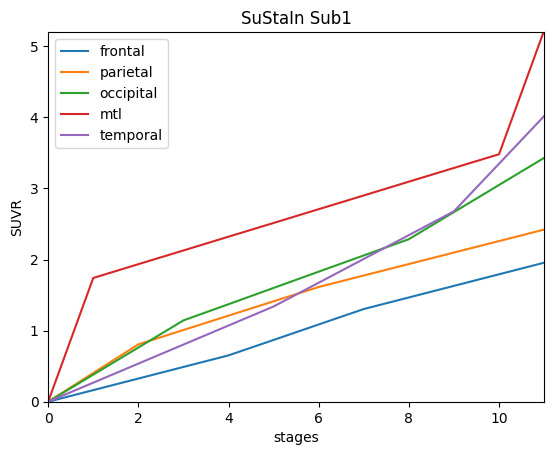

In [ ]:
for i in range(5):
    plt.plot(np.round(sv_adni[:,:,0],3)[i])

plt.xlabel('stages')
plt.ylabel('SUVR')
plt.xlim(0,11)
plt.ylim(0,5.2)
plt.title('SuStaIn Sub1')
plt.legend(['frontal','parietal','occipital','mtl','temporal'])

In [ ]:
ssed_adni1 = Run_SE_Recurse_Stage(sub_adni.squeeze(), adni, 'adni', 0, 0, np.array([1/4,1/4,1/4,1/4]))

Failed to find pickle file: /content/adni00/pickle_files/adni00_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -1540.474803689246


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni10/pickle_files/adni10_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -970.5678966101708


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni20/pickle_files/adni20_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -823.5281242799865


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni30/pickle_files/adni30_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -741.1912555588485


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

proportions:  [0.14410112 0.23695214 0.11316833 0.50577841]
likelihood:  -4027.1382278487104
Failed to find pickle file: /content/adni01/pickle_files/adni01_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -519.464737329742


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni11/pickle_files/adni11_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -1029.27621588355


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni21/pickle_files/adni21_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -402.4816376676228


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni31/pickle_files/adni31_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -1862.08329045285


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

proportions:  [0.10502496 0.25561785 0.08431699 0.5550402 ]
likelihood:  -3976.7708384184853
Failed to find pickle file: /content/adni02/pickle_files/adni02_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -437.2773161188659


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni12/pickle_files/adni12_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -1028.9802902076576


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni22/pickle_files/adni22_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -336.9567950605246


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni32/pickle_files/adni32_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -2009.2587727079713


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

proportions:  [0.09642841 0.24800468 0.08414378 0.57142313]
likelihood:  -3967.2830074147023
Failed to find pickle file: /content/adni03/pickle_files/adni03_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -344.77049207716925


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni13/pickle_files/adni13_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -950.2561961760441


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni23/pickle_files/adni23_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -374.6338173767258


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni33/pickle_files/adni33_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -2099.7895006035637


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

proportions:  [0.07800009 0.26879435 0.08330493 0.56990063]
likelihood:  -3918.7144015226622
Failed to find pickle file: /content/adni04/pickle_files/adni04_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -295.0615859643394


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni14/pickle_files/adni14_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -1016.7411011003078


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni24/pickle_files/adni24_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -374.6338173767258


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni34/pickle_files/adni34_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -2066.143402429413


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

proportions:  [0.07175322 0.32754639 0.08691974 0.51378065]
likelihood:  -3884.8965621568723
Failed to find pickle file: /content/adni05/pickle_files/adni05_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -271.0892020930135


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni15/pickle_files/adni15_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -1283.993352520946


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni25/pickle_files/adni25_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -374.6338173767258


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni35/pickle_files/adni35_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -1791.7348879717742


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

proportions:  [0.07000479 0.33453131 0.08807489 0.50738901]
likelihood:  -3883.258084155339
Failed to find pickle file: /content/adni06/pickle_files/adni06_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -271.0892020930135


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni16/pickle_files/adni16_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -1283.993352520946


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni26/pickle_files/adni26_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -374.6338173767258


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to find pickle file: /content/adni36/pickle_files/adni36_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -1791.7348879717742


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

proportions:  [0.06959013 0.33540278 0.08832787 0.50667922]
likelihood:  -3883.2321028861443


In [ ]:
from simfuncs import generate_random_Zscore_sustain_model, generate_data_Zscore_sustain
ls_sv_ssed = []
for i in range(4):
    _, _, sv_ssed_temp = generate_data_Zscore_sustain(np.array([0]),
                                             np.array([0]),
                                             ssed_adni1[1][i].squeeze(2),
                                             ssed_adni1[0][i].Z_vals,
                                             ssed_adni1[0][i].max_biomarker_zscore)
    ls_sv_ssed.append(np.round(sv_ssed_temp[:,:,0],3))

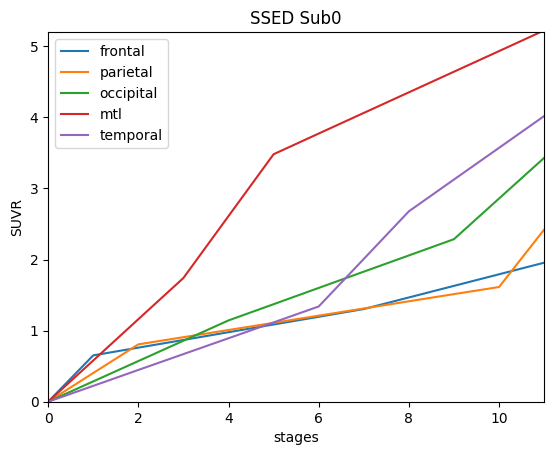

In [ ]:
for i in range(5):
    plt.plot(ls_sv_ssed[0][i])

plt.xlabel('stages')
plt.ylabel('SUVR')
plt.xlim(0,11)
plt.ylim(0,5.2)
plt.title('SSED Sub0')
plt.legend(['frontal','parietal','occipital','mtl','temporal'])